In [8]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_price_dom_assoc_quarter_mls_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
#merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

In [9]:
merged[['assoc_name_final','quarter','ln_list_price_sq_ft']].head(20)

,assoc_name_final,quarter,ln_list_price_sq_ft
3,"1 CYPRESS RUN, HOMOSASSA, FL 34446",2025-01-01,4.876766
4,"10 SE KINGS BAY DR, CRYSTAL RIVER, FL 34429",2024-04-01,NaN
6,"10009 VILLAGIO GARDENS LN, ESTERO, FL 33928",2025-07-01,5.260318
8,101 LOFTS CONDOMINIUM 33401,2024-10-01,6.596955
9,"101 NATURES WAY, ROTONDA WEST, FL 33947",2025-04-01,4.871310
10,"102 NATURES WAY, ROTONDA WEST, FL 33947",2025-01-01,5.054469
12,"10501 AMBERJACK WAY, ENGLEWOOD, FL 34224",2023-10-01,5.480735
13,"1061 S COLLIER BLVD, MARCO ISLAND, FL 34145",2024-01-01,NaN
14,"107 VISTA VERDI CIR, LAKE MARY, FL 32746",2025-07-01,5.000926
15,"10801 CROOKED RIVER RD, ESTERO, FL 34135",2023-07-01,5.717714


In [10]:
# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

In [11]:
event_window = range(-13, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)

In [23]:
#value_counts = merged['event_time'].value_counts()
#print(value_counts)

In [12]:
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

In [13]:
# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_13968\1398399657.py:11: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0012
Estimator:                    PanelOLS   R-squared (Between):              0.0095
No. Observations:                42700   R-squared (Within):              -0.0193
Date:                 Wed, Jan 21 2026   R-squared (Overall):              0.0025
Time:                         11:09:07   Log-likelihood                   -3521.5
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.6419
Entities:                         6225   P-value                           0.0192
Avg Obs:                        6.8594   Distribution:                F(27,36421)
Min Obs:                        1.0000                                           
Max Obs:                        29.000   F-statistic (robust):             1.7945
                

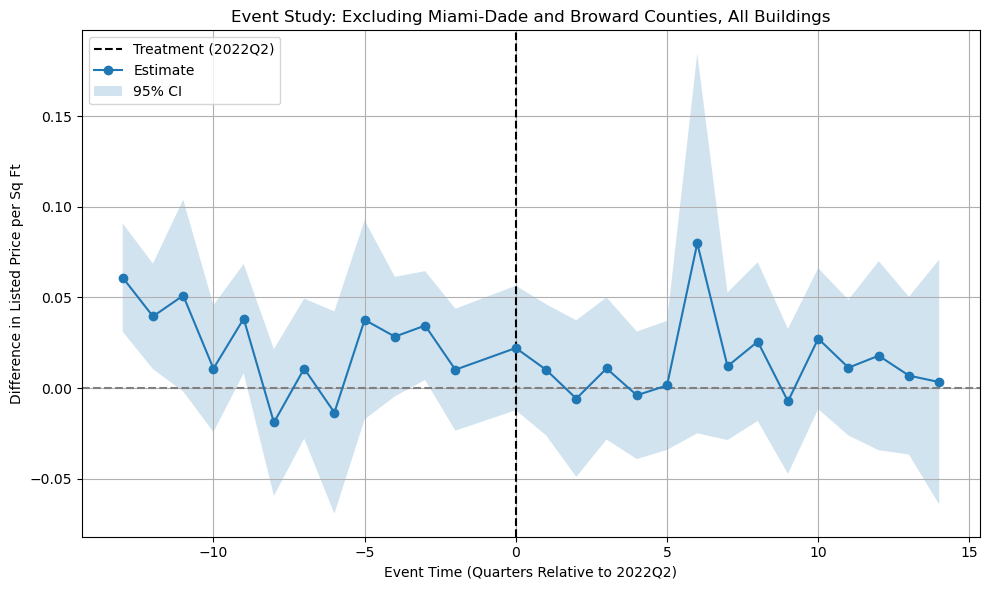

In [14]:
import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_list_price/event_study_lprice_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_5628\3073242990.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0038
Estimator:                    PanelOLS   R-squared (Between):             -0.0181
No. Observations:                10293   R-squared (Within):               0.0112
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0012
Time:                         17:06:10   Log-likelihood                 -2.21e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.1984
Entities:                         3009   P-value                           0.2333
Avg Obs:                        3.4207   Distribution:                 F(23,7238)
Min Obs:                        1.0000                                           
Max Obs:                        24.000   F-statistic (robust):             0.9666
                

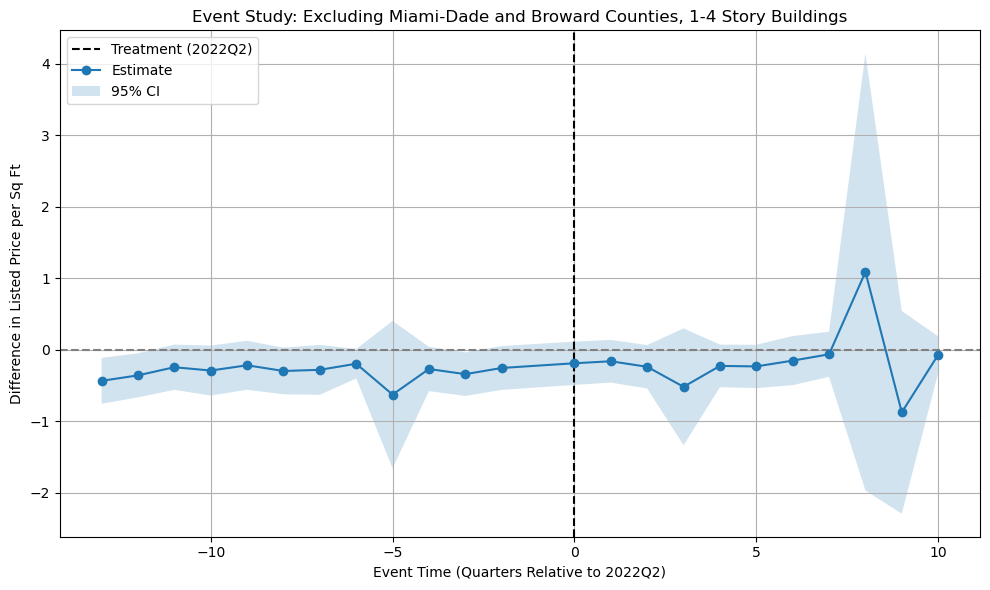

In [85]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_list_price/event_study_lprice_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_5628\2455889108.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0044
Estimator:                    PanelOLS   R-squared (Between):             -0.0142
No. Observations:                 6804   R-squared (Within):              -0.0235
Date:                 Wed, Jul 23 2025   R-squared (Overall):             -0.0089
Time:                         17:06:31   Log-likelihood                   -8849.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      0.9471
Entities:                         1801   P-value                           0.5335
Avg Obs:                        3.7779   Distribution:                 F(23,4957)
Min Obs:                        1.0000                                           
Max Obs:                        24.000   F-statistic (robust):             0.6109
                

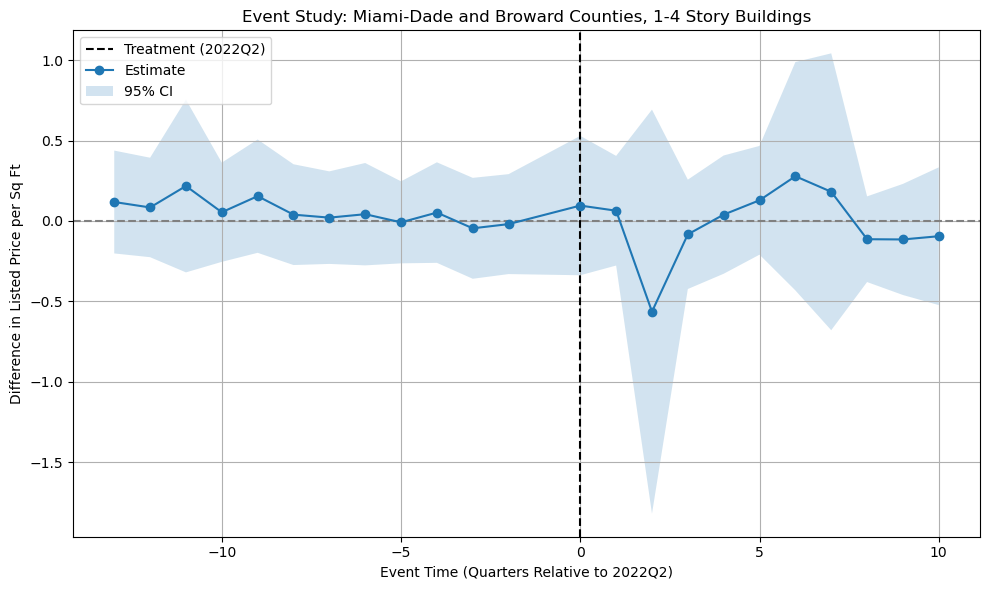

In [86]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_list_price/event_study_lprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_5628\672971881.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0027
Estimator:                    PanelOLS   R-squared (Between):             -0.0117
No. Observations:                16640   R-squared (Within):               0.0809
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0166
Time:                         17:06:41   Log-likelihood                -3.067e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.5835
Entities:                         2981   P-value                           0.0375
Avg Obs:                        5.5820   Distribution:                F(23,13613)
Min Obs:                        1.0000                                           
Max Obs:                        24.000   F-statistic (robust):             5.0802
                

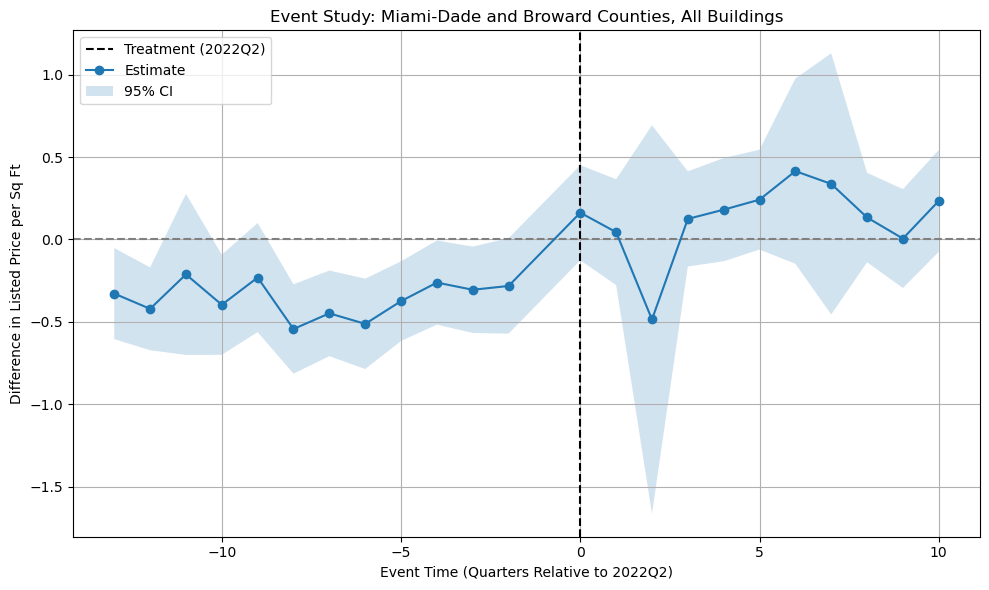

In [87]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_assoc_fe_list_price/event_study_lprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.2651
Estimator:                    PanelOLS   R-squared (Between):              0.0901
No. Observations:                15796   R-squared (Within):               0.2657
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.2695
Time:                         17:06:52   Log-likelihood                -3.385e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      152.28
Entities:                          114   P-value                           0.0000
Avg Obs:                        138.56   Distribution:                F(37,15622)
Min Obs:                        1.0000                                           
Max Obs:                        1217.0   F-statistic (robust):             23.519
                

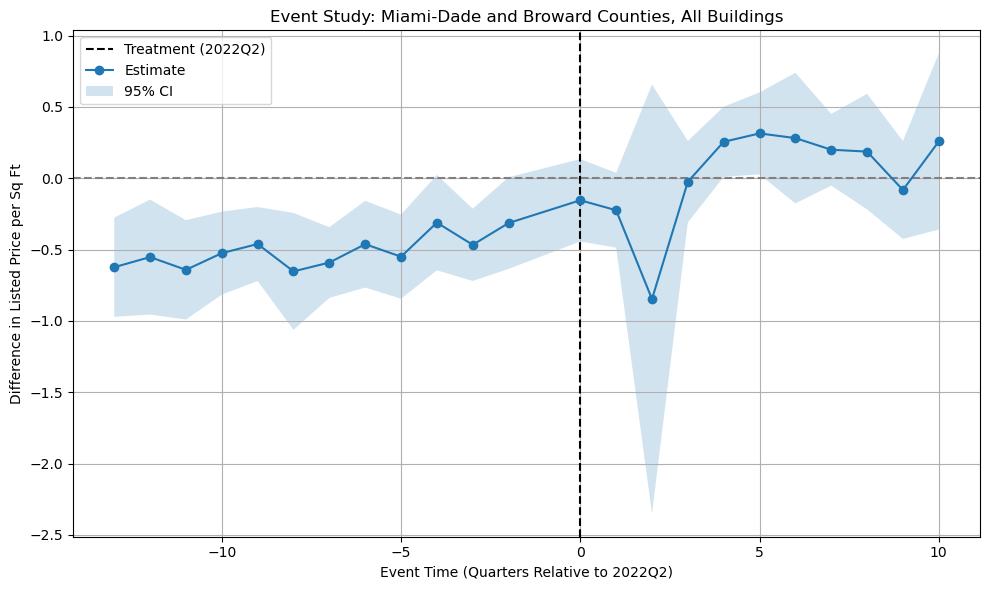

In [88]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_list_price/event_study_lprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0422
Estimator:                    PanelOLS   R-squared (Between):              0.0899
No. Observations:                 6474   R-squared (Within):               0.0089
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0461
Time:                         17:07:01   Log-likelihood                -1.084e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      7.5129
Entities:                          109   P-value                           0.0000
Avg Obs:                        59.394   Distribution:                 F(37,6305)
Min Obs:                        1.0000                                           
Max Obs:                        447.00   F-statistic (robust):             11.497
                

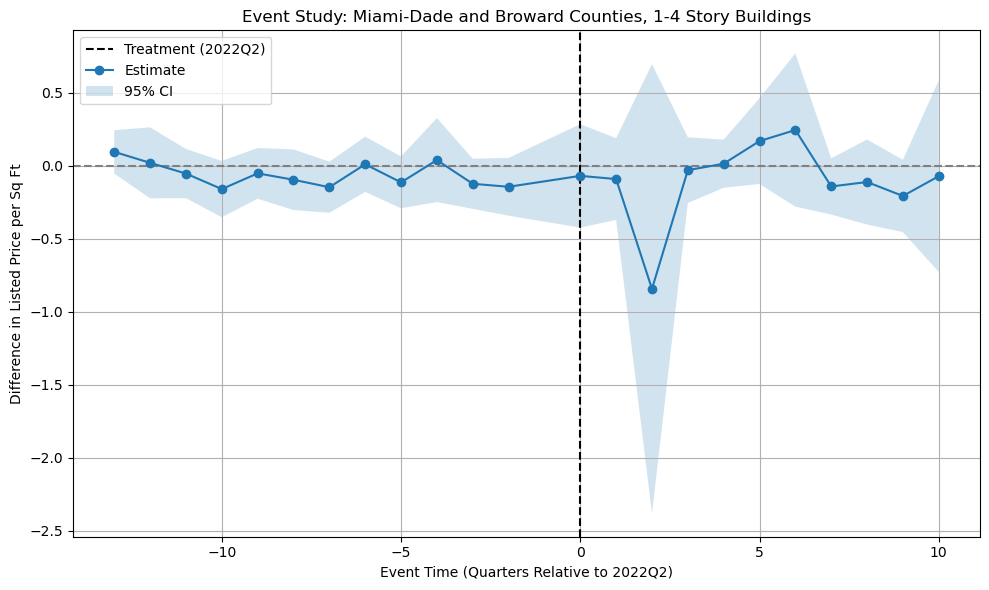

In [89]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_list_price/event_study_lprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0027
Estimator:                    PanelOLS   R-squared (Between):             -0.7917
No. Observations:                15106   R-squared (Within):               0.0043
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0020
Time:                         17:07:08   Log-likelihood                -8.293e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.0634
Entities:                          366   P-value                           0.3656
Avg Obs:                        41.273   Distribution:                F(37,14680)
Min Obs:                        1.0000                                           
Max Obs:                        404.00   F-statistic (robust):             2.2765
                

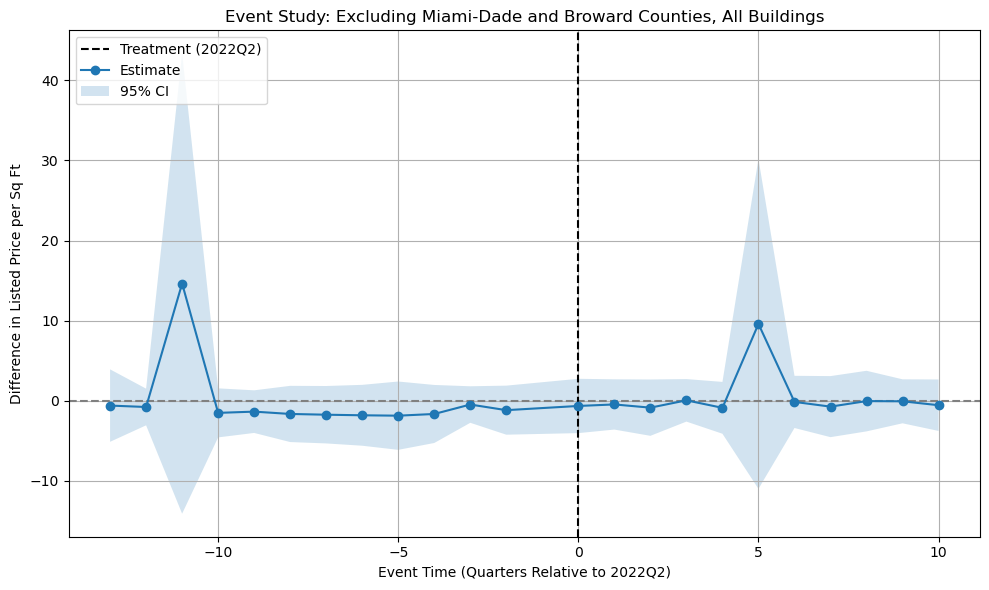

In [90]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, All Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_list_price/event_study_lprice_exc_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0115
Estimator:                    PanelOLS   R-squared (Between):              0.0520
No. Observations:                 8328   R-squared (Within):               0.0176
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0237
Time:                         17:07:17   Log-likelihood                -1.984e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      2.4878
Entities:                          350   P-value                           0.0000
Avg Obs:                        23.794   Distribution:                 F(37,7918)
Min Obs:                        1.0000                                           
Max Obs:                        201.00   F-statistic (robust):             3.0098
                

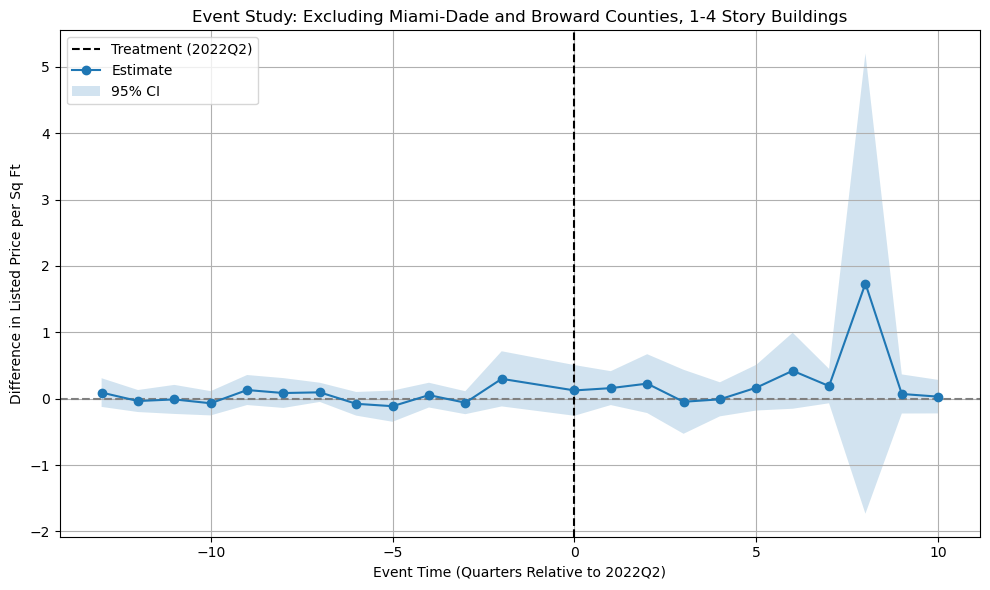

In [91]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[~merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2022Q2 (i.e., April 2022)
merged['event_time'] = (merged['year'] - 2022) * 4 + (merged['quarter_num'] - 2)

event_window = range(-13, 11)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr',
    'frac_npexcorp_state_attom_assoc', 'frac_corp_own_attom_assoc', 'corp_mgmt_city_attom_assoc' 
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2022Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Excluding Miami-Dade and Broward Counties, 1-4 Story Buildings')
plt.xlabel('Event Time (Quarters Relative to 2022Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_zip_fe_list_price/event_study_lprice_exc_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_5628\2649773760.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0044
Estimator:                    PanelOLS   R-squared (Between):             -0.0147
No. Observations:                 6804   R-squared (Within):              -0.0235
Date:                 Wed, Jul 23 2025   R-squared (Overall):             -0.0092
Time:                         17:07:26   Log-likelihood                   -8849.6
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      0.9471
Entities:                         1801   P-value                           0.5335
Avg Obs:                        3.7779   Distribution:                 F(23,4957)
Min Obs:                        1.0000                                           
Max Obs:                        24.000   F-statistic (robust):             0.6109
                

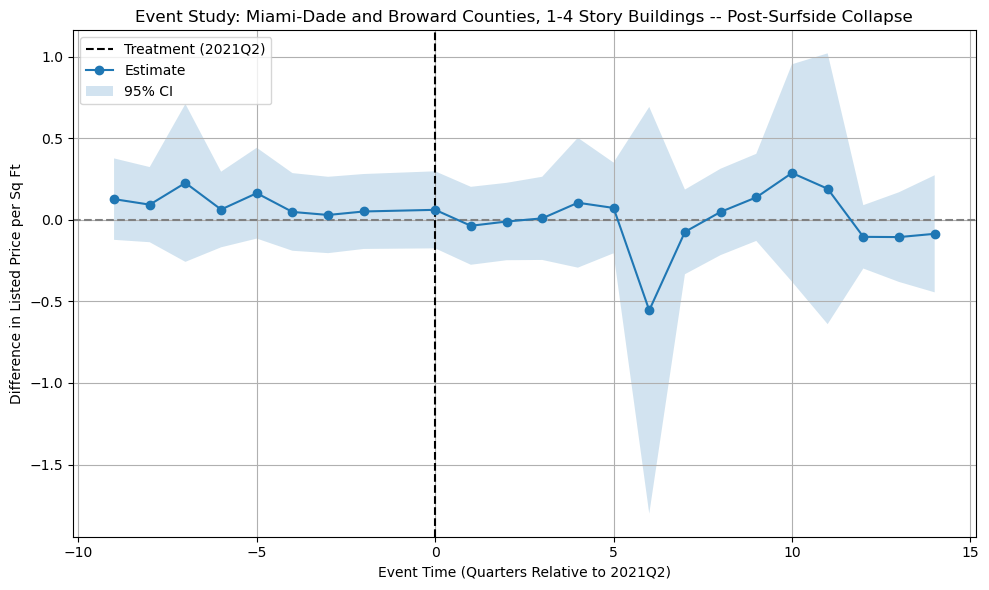

In [92]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_list_price/assoc_fe/event_study_surfside_lprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)
C:\Users\ngodin\AppData\Local\Temp\ipykernel_5628\1753122018.py:69: AbsorbingEffectWarning: 
Variables have been fully absorbed and have removed from the regression:

gym_redfin_assoc, pool_redfin_assoc, spa_broad_redfin_assoc, tennis_redfin_assoc, golf_redfin_assoc, garage_redfin_assoc, boat_redfin_assoc, elevator_redfin_assoc, view_redfin_assoc, senior_community_redfin_assoc, property_age_assoc_qtr

  res = mod.fit(cov_type='clustered', cluster_entity=True)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0027
Estimator:                    PanelOLS   R-squared (Between):              0.0042
No. Observations:                16640   R-squared (Within):               0.0809
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0249
Time:                         17:07:40   Log-likelihood                -3.067e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      1.5835
Entities:                         2981   P-value                           0.0375
Avg Obs:                        5.5820   Distribution:                F(23,13613)
Min Obs:                        1.0000                                           
Max Obs:                        24.000   F-statistic (robust):             5.0802
                

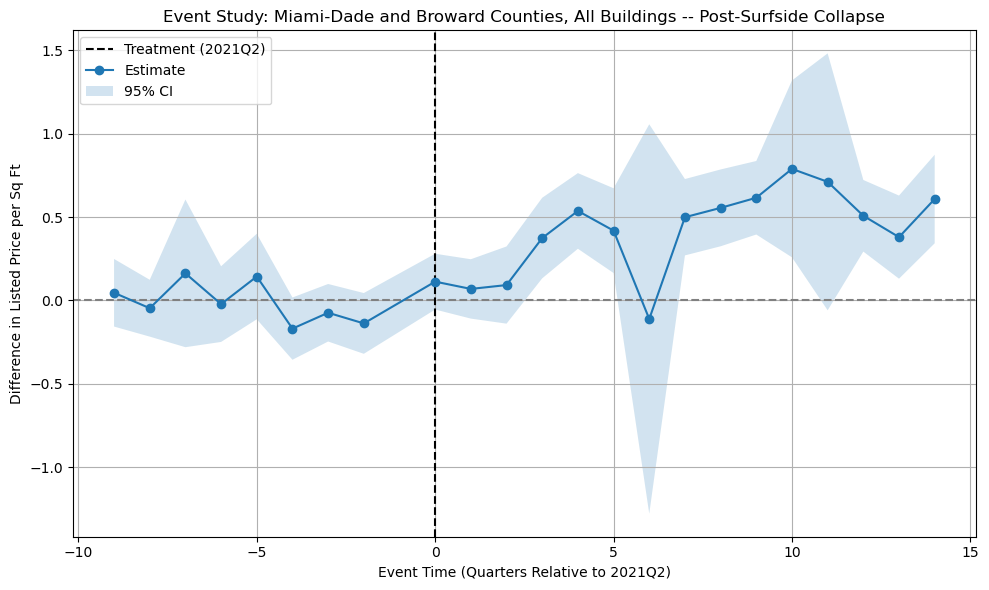

In [93]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: assoc_name_final and quarter
merged = merged.set_index(['assoc_name_final', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # association FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_list_price/assoc_fe/event_study_surfside_lprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.0354
Estimator:                    PanelOLS   R-squared (Between):              0.0971
No. Observations:                 6804   R-squared (Within):               0.0039
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.0221
Time:                         17:07:58   Log-likelihood                -1.132e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      7.1607
Entities:                          110   P-value                           0.0000
Avg Obs:                        61.855   Distribution:                 F(34,6637)
Min Obs:                        1.0000                                           
Max Obs:                        454.00   F-statistic (robust):             6.5042
                

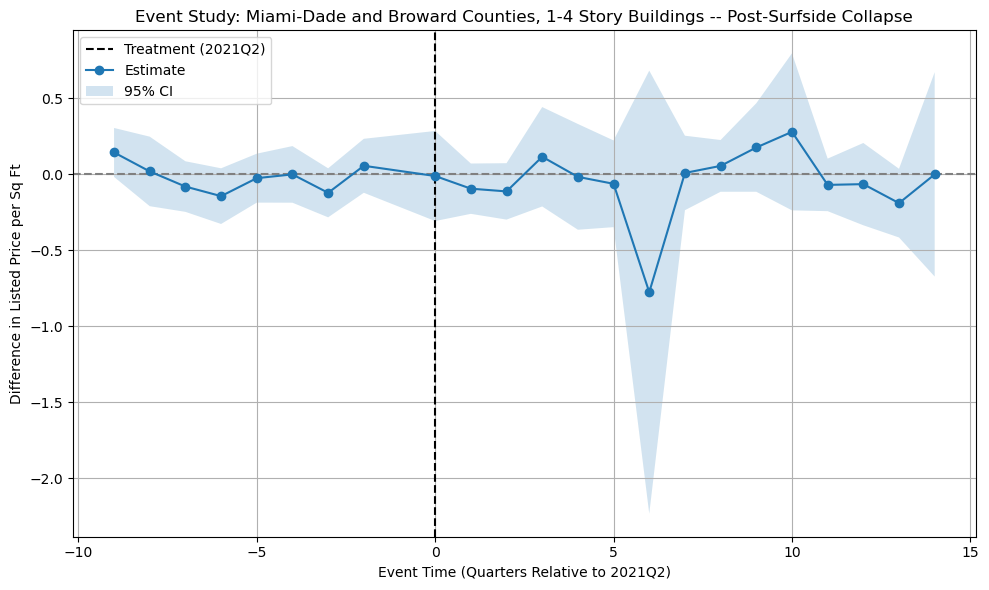

In [94]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, 1-4 Story Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_list_price/zip_fe/event_study_surfside_lprice_miami_less5_bldg.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\ngodin\anaconda3\lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


                           PanelOLS Estimation Summary                           
Dep. Variable:     ln_list_price_sq_ft   R-squared:                        0.1654
Estimator:                    PanelOLS   R-squared (Between):              0.0260
No. Observations:                16640   R-squared (Within):               0.1676
Date:                 Wed, Jul 23 2025   R-squared (Overall):              0.1704
Time:                         17:08:18   Log-likelihood                -3.997e+04
Cov. Estimator:              Clustered                                           
                                         F-statistic:                      96.016
Entities:                          115   P-value                           0.0000
Avg Obs:                        144.70   Distribution:                F(34,16468)
Min Obs:                        1.0000                                           
Max Obs:                        1250.0   F-statistic (robust):             16.807
                

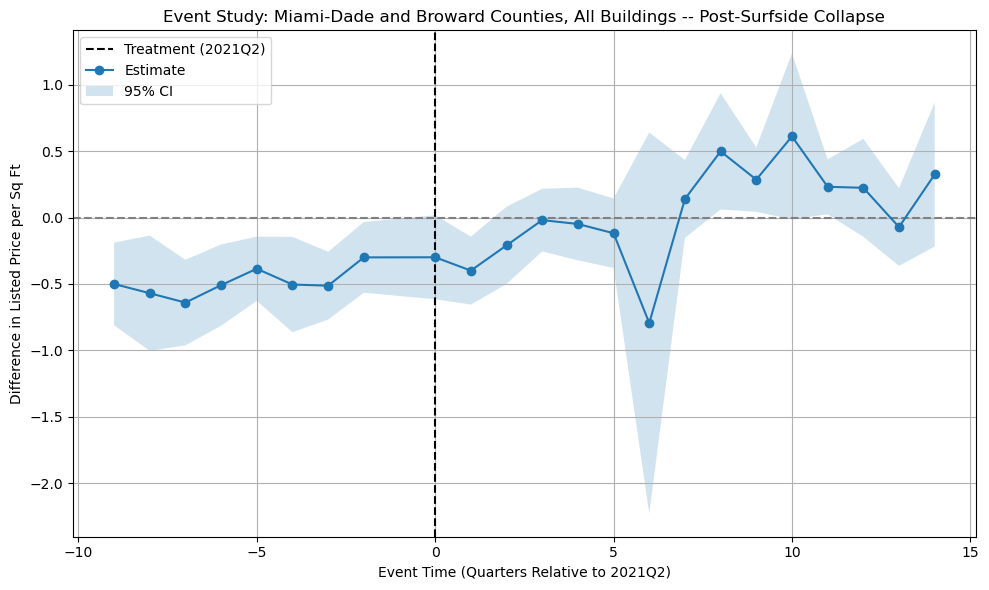

In [95]:
import pandas as pd
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
import numpy as np

merged = pd.read_stata('../../final_datasets/master_datasets/master_dataset_assoc_quarter_redfin.dta')
# weights = pd.read_stata('../../final_datasets/master_datasets/hoa_redfin_weights.dta')

# merged = hoa_df.merge(weights[['assoc_name_final', 'quarter', 'final_weight']], on=['assoc_name_final', 'quarter'], how='left')
merged = merged[merged['mm_fips_county_name_attom'].isin(['MIAMI-DADE', 'BROWARD'])]
# Fill in weights after 2023Q2 with one
# cutoff = pd.Timestamp('2023-07-01')          # start of 2023 Q3
# mask   = (merged['quarter'] >= cutoff) & merged['final_weight'].isna()
# merged.loc[mask, 'final_weight'] = 1.0
# Subset to 4 stories or less
#merged = merged[(merged['num_stories_final_assoc'].notna()) & (merged['num_stories_final_assoc'] <= 4)]

# merged['ln_list_price_sq_ft'] = np.log(merged['list_price_sq_ft_assoc_qtr'])
merged['ln_list_price_sq_ft'] = merged['list_price_sq_ft_assoc_qtr']/100

# Extract year and quarter from timestamp
merged['year'] = merged['quarter'].dt.year
merged['month'] = merged['quarter'].dt.month

# Convert month to calendar quarter (1 → Q1, 4 → Q2, etc.)
merged['quarter_num'] = ((merged['month'] - 1) // 3) + 1

# Compute event time relative to 2021Q2 (i.e., June 2021)
merged['event_time'] = (merged['year'] - 2021) * 4 + (merged['quarter_num'] - 2)

event_window = range(-9, 15)
event_dummies = []

for k in event_window:
    if k == -1:
        continue  # baseline
    colname = f'g_{k}_treated'
    merged[colname] = ((merged['event_time'] == k) & (merged['treated_assoc'] == 1)).astype(int)
    event_dummies.append(colname)
    
# Set multi-index for panel regression: zip5_attom and quarter
merged = merged.set_index(['zip5_attom', 'quarter'])

# Dependent variable
y = merged['ln_list_price_sq_ft']

# Other covariates
covariates = [
    'gym_redfin_assoc', 'pool_redfin_assoc', 'spa_broad_redfin_assoc',
    'tennis_redfin_assoc', 'golf_redfin_assoc', 'garage_redfin_assoc',
    'boat_redfin_assoc', 'elevator_redfin_assoc', 'view_redfin_assoc',
    'senior_community_redfin_assoc', 'property_age_assoc_qtr'
]

# Combine X matrix
X = merged[event_dummies + covariates]
X = sm.add_constant(X)

# Run weighted fixed-effects regression
mod = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True,   # zip FE
    time_effects=True,     # quarter FE
#     weights=merged['final_weight'],
    drop_absorbed=True
)

res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res.summary)

import matplotlib.pyplot as plt

# Extract event-time interaction coefficients
params = res.params
conf_int = res.conf_int()

event_times = []
coefs = []
ci_low = []
ci_high = []

for col in event_dummies:
    k = int(col.split('_')[1])
    event_times.append(k)
    coefs.append(params[col])
    ci_low.append(conf_int.loc[col][0])
    ci_high.append(conf_int.loc[col][1])

plot_df = pd.DataFrame({
    'event_time': event_times,
    'coef': coefs,
    'ci_lower': ci_low,
    'ci_upper': ci_high
}).sort_values('event_time')

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='black', linestyle='--', label='Treatment (2021Q2)')
plt.plot(plot_df['event_time'], plot_df['coef'], marker='o', label='Estimate')
plt.fill_between(plot_df['event_time'], plot_df['ci_lower'], plot_df['ci_upper'], alpha=0.2, label='95% CI')

plt.title('Event Study: Miami-Dade and Broward Counties, All Buildings -- Post-Surfside Collapse')
plt.xlabel('Event Time (Quarters Relative to 2021Q2)')
plt.ylabel('Difference in Listed Price per Sq Ft')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.savefig('output/plot_surfside_list_price/zip_fe/event_study_surfside_lprice_miami_all_bldg.png', dpi=300, bbox_inches='tight')
plt.show()